<bound method NDFrame.head of         hit_id         particle_id          tx         ty      tz  \
0            1                   0  -64.411598  -7.164120 -1502.5   
1            2   22525763437723648  -55.338501   0.630805 -1502.5   
2            3                   0  -83.828003  -1.145580 -1502.5   
3            4  297237712845406208  -96.122902  -8.230360 -1502.5   
4            5  418835796137607168  -62.659401  -9.375040 -1502.5   
...        ...                 ...         ...        ...     ...   
120934  120935  445864815605317632 -763.383972  51.544998  2944.5   
120935  120936  900720956266250240 -804.664978   3.186900  2944.5   
120936  120937  238705348779704320 -986.989014  41.731300  2952.5   
120937  120938  373800349619716096 -947.005005  18.764999  2952.5   
120938  120939  238694972138717184 -926.257019   2.309990  2952.5   

                  tpx            tpy            tpz    weight  
0       250710.000000 -149908.000000 -956385.000000  0.000000  
1           -

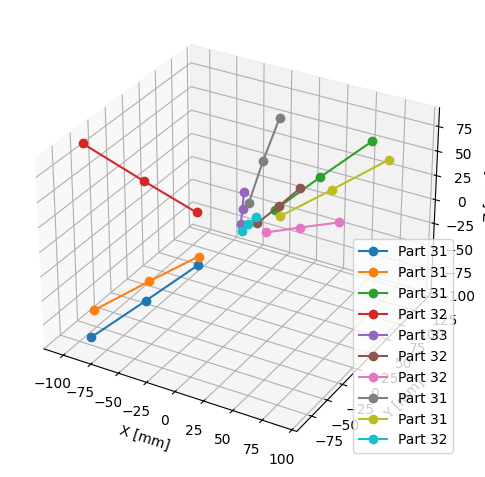

In [1]:
from trackml.dataset import load_event
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import os
from kalman_filter import filtering_by_theta, hits_vertex
from top_momentum_module import top_momentum
import metric_scores
import importlib
importlib.reload(metric_scores)
from metric_scores import  valid_tracks_from_best_hits, valid_tracks_from_kalman_tracks, valid_tracks_from_kalman_tracks_no_pid
from iter_trayectorias import get_hits_dict, track_finding_from_triplet_coords

# 1. Carga evento completo
event = 'event000001000'
path = r'/mnt/d/TFG - Dataset/DATASET/train_1/'


hits, cells, particles, truth = load_event(path + event)
print(truth.head)
PARTICLES_FROM_VERTEX = True
hits, particles, truth_filtered = hits_vertex(hits, particles, truth, PARTICLES_FROM_VERTEX= PARTICLES_FROM_VERTEX)


# 4. Prepara hits dict y volúmenes según tu setup previo
thetamin, thetamax = filtering_by_theta(hits)

# Selección de volúmenes
volume_ids = hits['volume_id'].unique()
volume_ids = volume_ids[[1, 4, 7]]  
first_volume = volume_ids[0]

pt_min = 0.5
pt_max = np.inf

hits_dict = get_hits_dict(hits, volume_ids, OCTANTE=False, angle_range=None, pt_range = (pt_min, pt_max))


# 1) Carga CSV de seeds (cilíndricas)
path_csv = r'/mnt/d/TFG - Dataset/'
triplets_df = pd.read_csv(os.path.join(path_csv, "para_titi.csv"))

# 2) Filtra por evento
event_number = int(event[-6:])
triplets_df = triplets_df[triplets_df["event"] == event_number]

# 3) Une con hits para traer particle_id y layer_id
#    Asume que `hits` ya contiene ['hit_id','particle_id','volume_id','layer_id',...]
merged = triplets_df.merge(
    hits[['hit_id','particle_id','volume_id','layer_id']],
    on='hit_id', how='inner'
)

# 4) Filtra sólo volume_id=8 y layers {2,4,6}
merged = merged[
    (merged.volume_id == 8) &
    (merged.layer_id.isin([2,4,6]))
]

# 5) Añádele el ángulo plano phi (renombrando theta)
merged = merged.rename(columns={'theta':'phi'})

# 6) Ordena por cada partícula y por radio (o z si prefieres)
merged = merged.sort_values(['particle_id','r'])

# 7) Construcción de tripletes: UN hit de CADA layer {2,4,6}
triplets = []
for pid, grp in merged.groupby('particle_id'):
    grp = grp.reset_index(drop=True)
    # hacemos sliding window de tamaño 3
    for i in range(len(grp)-2):
        block = grp.iloc[i:i+3]
        layers = set(block['layer_id'])
        # sólo nos quedamos con los bloques que contengan exactamente {2,4,6}
        if layers == {2,4,6}:
            coords_cil = block[['r','phi','z']].values  # shape (3,3)
            triplets.append(coords_cil)

triplets = np.array(triplets)  # (N_tripletes, 3, 3)

# 8) Pasa a cartesianas
def polar_to_cartesian(r, phi, z):
    x = r * np.cos(phi)
    y = r * np.sin(phi)
    return np.stack([x,y,z], axis=-1)

r   = triplets[...,0]
phi = triplets[...,1]
z   = triplets[...,2]
X_triplets = polar_to_cartesian(r, phi, z)  # (N,3,3)

# 9) Visualiza unos pocos en 3D
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D

N = min(10, X_triplets.shape[0])
fig = plt.figure()
ax  = fig.add_subplot(111, projection='3d')
for i in range(N):
    pts = X_triplets[i]
    ax.plot(pts[:,0], pts[:,1], pts[:,2], '-o',
            label=f'Part {int(triplets[i][0,0])}')
ax.set_xlabel('X [mm]'); ax.set_ylabel('Y [mm]'); ax.set_zlabel('Z [mm]')
ax.legend()
plt.tight_layout()
plt.show()


In [2]:
# 5. Importa funciones de Kalman (según tu código)
from kalman_filter import apply_kalmanfilter, get_initial_state, campo_magnetico, apply_lorentz_correction

# 6. Aplica filtro de Kalman a todos los tripletes sin separar por bins:


def get_hit_id_from_coords(hit_coords, hits_df, tol=5e-2):
    # Dado un vector [x,y,z], busca en hits_df el hit_id que tiene esas coords dentro de tol
    cond_x = np.isclose(hits_df['x'], hit_coords[0], atol=tol)
    cond_y = np.isclose(hits_df['y'], hit_coords[1], atol=tol)
    cond_z = np.isclose(hits_df['z'], hit_coords[2], atol=tol)
    cond = cond_x & cond_y & cond_z
    hit_ids = hits_df.loc[cond, 'hit_id'].values
    
    return hit_ids[0]

data_dir = '/mnt/d/TFG - Dataset/OUTPUT' 
event = 'event000001000'

data = np.load(os.path.join(data_dir, f'triplets_tp_descaled_{event}.npz'))
triplets_tp = data["triplets"]
print("Tripletes TP cargados:", triplets_tp.shape)

X_triplets = triplets_tp

all_tracks, all_hits_vecinos_por_track, top_particles, volume_ids, hits_dict_all_volumes, truth_filtered, triplet_precision = track_finding_from_triplet_coords(
    X_triplets,
    hits,
    truth_filtered,
    particles,
    volume_ids,
    hits_dict,
    DT=1.0,
    COS_THRESHOLD=1.0,
    Q_COEFF_BASE=0.01,
    SMOOTHING=True
)

from kalman_filter import construir_trayectorias_truth_weight  

#trayectorias_truth, pesos_truth = construir_trayectorias_truth_weight(truth, min_hits_por_particula=10, OCTANTE=False)

# Inicializa lista para resultados si no existe
all_results = []
#truth_filtered = truth
# Añadir resultados de esta ejecución
all_results.append({
    "pt_range": (pt_min, pt_max),
    "tracks": all_tracks,
    "hits_vecinos": all_hits_vecinos_por_track,
    "particles": top_particles,
    "truth": truth_filtered
})

# Construir trayectorias del truth y pesos
trayectorias_truth, pesos_truth = construir_trayectorias_truth_weight(truth)
print(f"✅ Total trayectorias truth construidas: {len(trayectorias_truth)}")
all_results[-1]["trayectorias_truth"] = trayectorias_truth
all_results[-1]["pesos_truth"] = pesos_truth

# Calcular precisión de tracks válidos (matching con truth)
valid_tracks, valid_track_indices, track_to_pid = valid_tracks_from_best_hits(
    all_hits_vecinos_por_track, truth_filtered, min_ratio=0.5, threshold=5.0
)

total_tracks = len(all_hits_vecinos_por_track)
purity = valid_tracks / total_tracks * 100 if total_tracks > 0 else 0.0

all_results[-1]["precision"] = purity
all_results[-1]["valid_tracks"] = valid_tracks
all_results[-1]["total_tracks"] = total_tracks
all_results[-1]["triplet_precision"] = triplet_precision

print(f"\n🎯 Resultados para rango pT ∈ [{pt_min}, {pt_max}]:")
print(f"→ Tracks válidos: {valid_tracks}/{total_tracks}")
print(f"→ Pureza (tracks): {purity:.2f}%")
print(f"→ Pureza (tripletes): {triplet_precision:.2f}%")
num_trayectorias_truth = truth_filtered['particle_id'].nunique()
print(f"Total de trayectorias en el truth filtrado: {num_trayectorias_truth}")
efficiency = valid_tracks/num_trayectorias_truth * 100
print(f"→ Eficiencia (tracks): {efficiency:.2f} %")



Tripletes TP cargados: (925, 3, 3)
Rango pT: 0.10 - 45.35 GeV/c
Total tracks: 925, Positivos: 470, Negativos: 455
Tripletes correctos (mismo PID): 925/925 (100.00%)
✅ Total trayectorias truth construidas: 7044

🎯 Resultados para rango pT ∈ [0.5, inf]:
→ Tracks válidos: 410/925
→ Pureza (tracks): 44.32%
→ Pureza (tripletes): 100.00%
Total de trayectorias en el truth filtrado: 3232
→ Eficiencia (tracks): 12.69 %


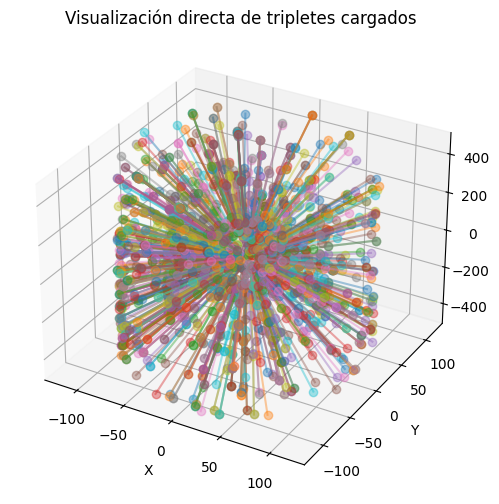

In [3]:
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D

fig = plt.figure(figsize=(6, 6))
ax = fig.add_subplot(111, projection='3d')

for triplet in X_triplets[:]:  # solo los primeros 100 por claridad
    xs, ys, zs = triplet[:, 0], triplet[:, 1], triplet[:, 2]
    ax.plot(xs, ys, zs, marker='o', alpha=0.4)

ax.set_xlabel('X')
ax.set_ylabel('Y')
ax.set_zlabel('Z')
plt.title("Visualización directa de tripletes cargados")
plt.show()


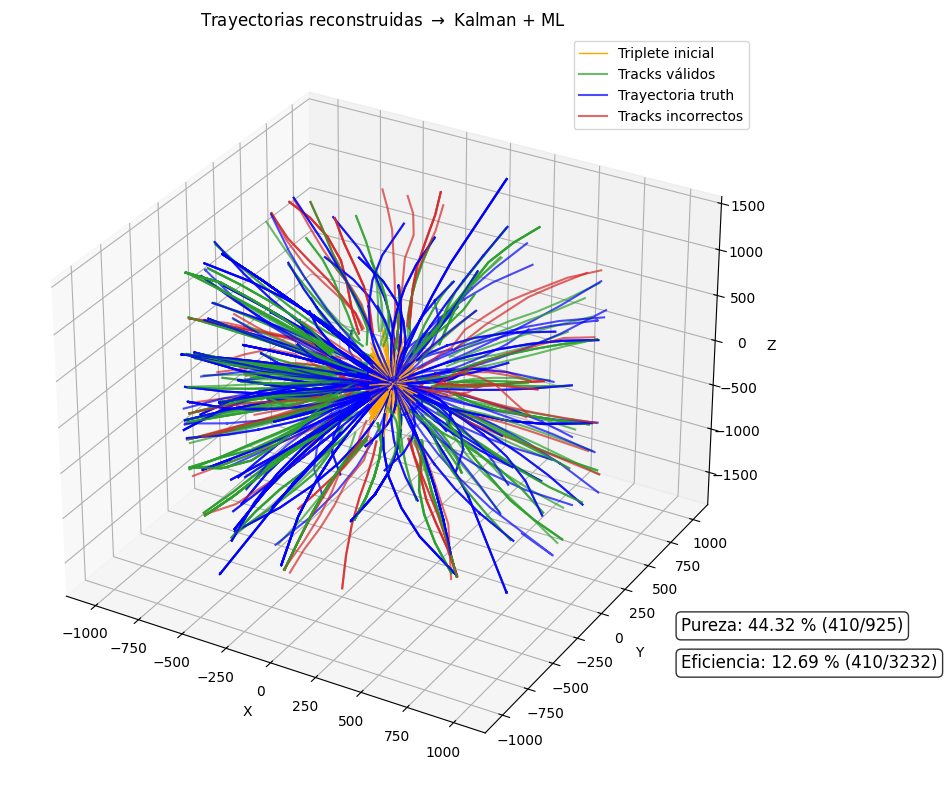

In [11]:
# === Visualización de tracks válidos e inválidos + tripletes iniciales ===
import random
import matplotlib
matplotlib.use('TkAgg')  # O 'Qt5Agg' si tienes Qt5 instalado
import matplotlib.pyplot as plt

from mpl_toolkits.mplot3d.art3d import Line3DCollection

# Cantidad de trayectorias a visualizar
N = 400

# Índices válidos e inválidos
valid_indices = valid_track_indices
invalid_indices = [i for i in range(total_tracks) if i not in valid_indices]

# Número de tracks válidos e inválidos a muestrear
num_valid = min(int(0.8 * N), len(valid_indices))
num_invalid = max(min(N - num_valid, len(invalid_indices)), 0)

sampled_valids = random.sample(list(valid_indices), num_valid) if num_valid > 0 else []
sampled_invalids = random.sample(list(invalid_indices), num_invalid) if num_invalid > 0 else []

indices_to_plot = sampled_valids + sampled_invalids
random.shuffle(indices_to_plot)

fig = plt.figure(figsize=(12, 8))
ax = fig.add_subplot(111, projection='3d')

label_valid_done = False
label_invalid_done = False
label_truth_done = False
label_triplet_done = False

# Diccionario para acceder rápidamente a coordenadas por hit_id
hit_coords_dict = hits.set_index('hit_id')[['x', 'y', 'z']].to_dict('index')

for idx in indices_to_plot:
    track = all_tracks[idx]

    # Obtener trayectorias del truth
    if idx in track_to_pid:
        pid = track_to_pid[idx]
        tray_truth_df = truth_filtered[truth_filtered['particle_id'] == pid]
        tray_truth = tray_truth_df[['tx', 'ty', 'tz']].values
    else:
        tray_truth = np.zeros((0, 3))

    is_valid = idx in valid_track_indices
    color = 'tab:green' if is_valid else 'tab:red'

    label_track = ""
    if is_valid and not label_valid_done:
        label_track = "Tracks válidos"
        label_valid_done = True
    elif not is_valid and not label_invalid_done:
        label_track = "Tracks incorrectos"
        label_invalid_done = True

    label_truth = ""
    if len(tray_truth) > 0 and not label_truth_done:
        label_truth = "Trayectoria truth"
        label_truth_done = True

    #=== Añadir triplete inicial ===
    triplet_coords = []
    if idx < len(X_triplets):
        hit_ids_triplet = X_triplets[idx]  
        for hit_coords in hit_ids_triplet:
            # Busca el hit_id más cercano a esas coordenadas
            hit_id = get_hit_id_from_coords(hit_coords, hits, tol=5e-2)
            if hit_id in hit_coords_dict:
                triplet_coords.append(list(hit_coords_dict[hit_id].values()))
        triplet_coords = np.array(triplet_coords)

        if triplet_coords.shape == (3, 3):
            ax.plot(triplet_coords[:, 0], triplet_coords[:, 1], triplet_coords[:, 2],
                    color='orange', linestyle='-', linewidth=1,
                    label="Triplete inicial" if not label_triplet_done else None)
            label_triplet_done = True

    # === Plot del track reconstruido ===
    ax.plot(track[:, 0], track[:, 1], track[:, 2], color=color, alpha=0.7, label=label_track if label_track else None)


    # === Plot de la trayectoria truth ===
    if len(tray_truth) > 0:
        ax.plot(tray_truth[:, 0], tray_truth[:, 1], tray_truth[:, 2],
                color='blue', alpha=0.7, linestyle='-', label=label_truth)
%matplotlib inline
textstr1 = f"Pureza: {purity:.2f} % ({(valid_tracks)}/{total_tracks})"
textstr2 = f"Eficiencia: {efficiency:.2f} % ({(valid_tracks)}/{int(num_trayectorias_truth)})"

# Añadir cajas de texto en la figura (coordenadas relativas 2D)
ax.text2D(0.9, 0.2, textstr1, transform=ax.transAxes, fontsize=12,
        bbox=dict(facecolor='white', alpha=0.8, boxstyle='round'))

ax.text2D(0.9, 0.15, textstr2, transform=ax.transAxes, fontsize=12,
        bbox=dict(facecolor='white', alpha=0.8, boxstyle='round'))

ax.set_xlabel('X')
ax.set_ylabel('Y')
ax.set_zlabel('Z')
ax.set_title(r'Trayectorias reconstruidas $\rightarrow$ Kalman + ML')
ax.legend()
plt.tight_layout()
plt.show()